<h1> sourdough microbiome and flavor </h1>


In the original study, 40 starters were picked for functional analysis and 17 were associated with green apple or fruity aromas. These "fruity starters" sound very intriguing to me and I want to try to culture one for myself and see if they impart the fruity notes to my bread. To do that I'll have to mimic the conditions that these starters were cultured in and I'll start with visualising the metadata of these 17 starters.

In [251]:
%matplotlib inline 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

<h3> Initial analysis of sourdough starters with fruity/apple notes </h3>

In [261]:
# read metadata for starters
metadata = pd.read_csv('metadata500_starters.csv')
metadata.rename(columns={'Unnamed: 0': 'sample'}, inplace=True)

# read sensory note file and filter for samples with apple/fruit aromas
sensory = pd.read_excel('Figure_4_-_Source_Data_2.xlsx')
mask = sensory['Note 1 (Dominant)'].str.contains(r'fruit|apple') | sensory['Note 2 (Secondary)'].str.contains(r'fruit|apple')

# get metadata for desired samples
desired_samples = metadata[metadata['sample'].isin(sensory['Sample'][mask])]

print(desired_samples.columns)
print()
print(f'{desired_samples["Country"].value_counts()}')

Index(['sample', 'sample_type', 'Type', 'Flag', 'Entry.Id', 'CurrentLat',
       'CurrentLong', 'grain.base.rye', 'grain.base.bleached.wheat',
       'grain.base.whole.wheat', 'grain.base.unbleached', 'City',
       'State.Province.Region', 'Country', 'Starter.age.years', 'WhoMadeBin',
       'StorageLocBin', 'FeedPerMo', 'Fruity', 'Sour', 'musty', 'medicinal',
       'biscuity', 'floral', 'NoSmell', 'FreqOpenedPerWeek', 'tap', 'filtered',
       'bottled', 'rainwater', 'snow', 'well', 'otherWater', 'Cat', 'Dog',
       'ContainerMaterial', 'ContainerLid', 'Temp', 'Seasnlty', 'MaxTemp',
       'MinTemp', 'Prec', 'npp'],
      dtype='object')

Country
United States    14
Canada            3
Name: count, dtype: int64


Note that the metadata also includes aroma descriptors that are self-reported and since every individual preceives smells differently, I won't be using them. I will also be ignoring any factors that I cannot control, such as country, presence of pets etc.

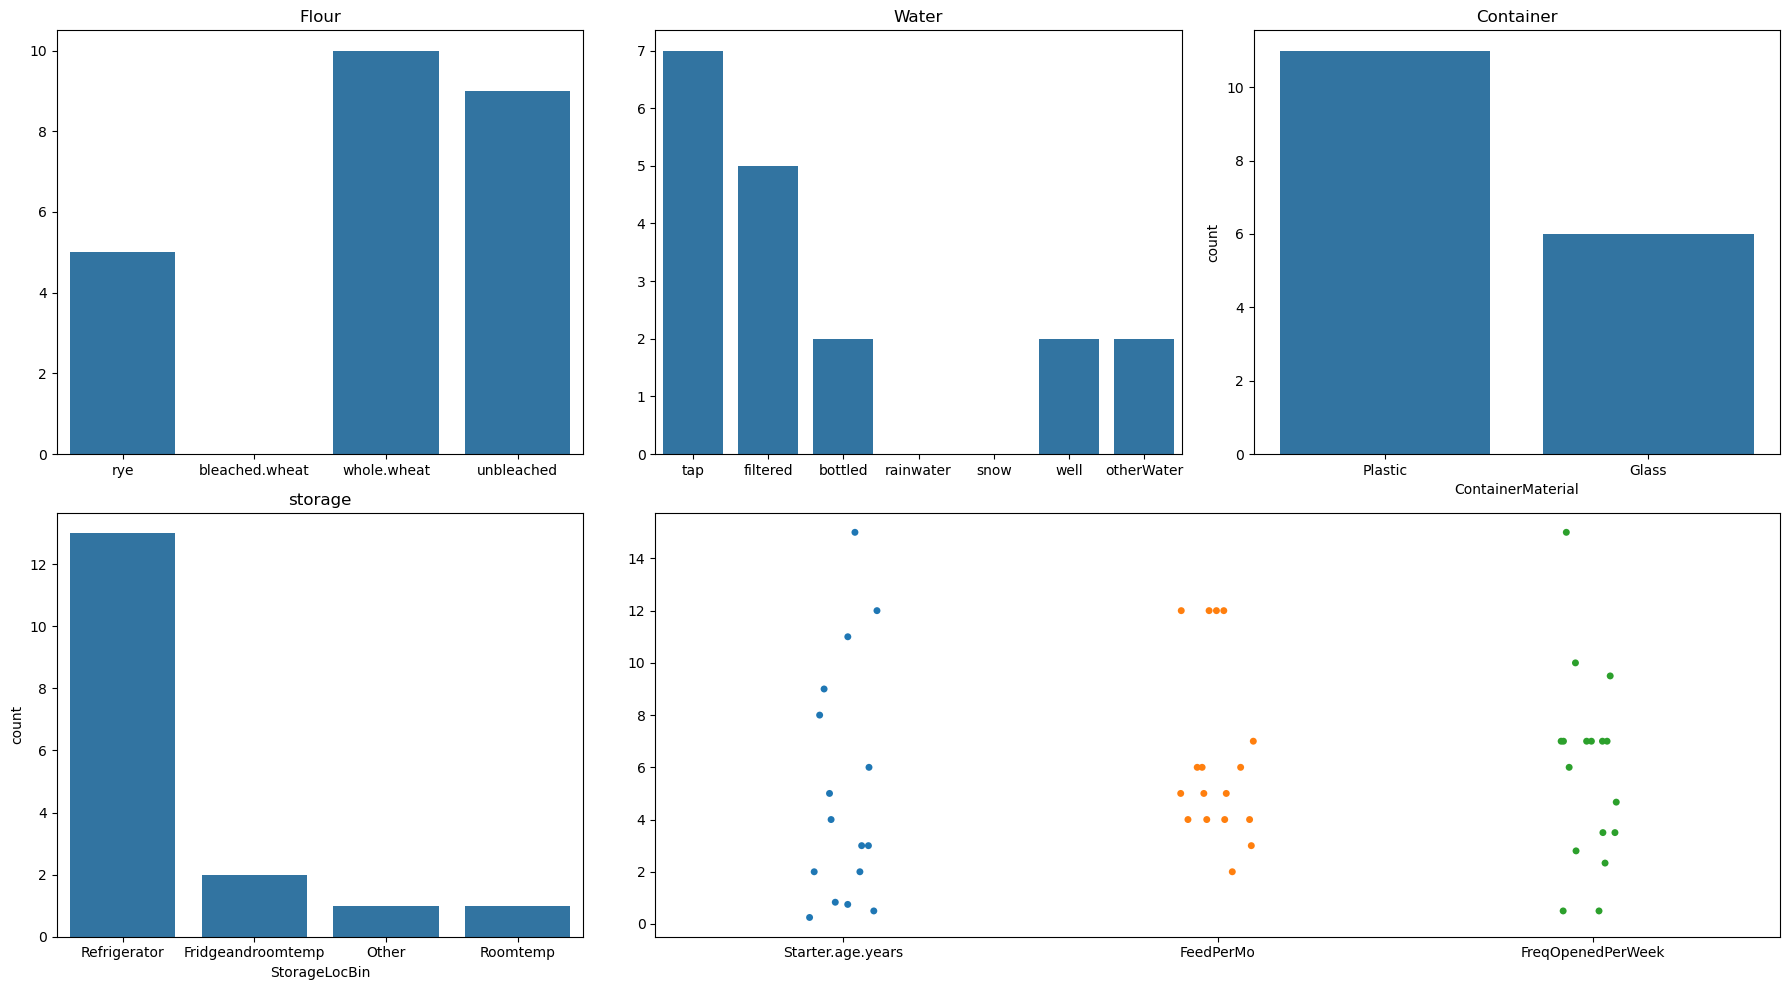

In [255]:
# visualize relevant metadata

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2,3)

ax1 = fig.add_subplot(gs[0,0])
sns.barplot(desired_samples.iloc[:, 7:11].sum(axis=0), ax=ax1)
ax1.set_xticks(range(4), labels = [i.replace('grain.base.', '') for i in desired_samples.iloc[:, 7:11].columns])
ax1.set_title('Flour')


ax2 = fig.add_subplot(gs[0,1])
sns.barplot(desired_samples.iloc[:, 26:33].sum(axis=0), ax=ax2)
ax2.set_title('Water')


ax3 = fig.add_subplot(gs[0,2])
sns.countplot(x=desired_samples.iloc[:, 35], ax=ax3)
ax3.set_title('Container')


ax4 = fig.add_subplot(gs[1,0])
sns.countplot(x = desired_samples.iloc[:, 16], ax=ax4)
ax4.set_title('storage')


ax5 = fig.add_subplot(gs[1,1:])
sns.stripplot(desired_samples.iloc[:, [14,17,25]])

plt.tight_layout()


From the plots, it is pretty clear the 17 starters are cultured in quite different conditions and there is a wide range of ages and feeding frequency as well. Some participants also used a mixture of flours and waters in the starters so the total for these categories is larger than 17. The conclusion after this initial exploration is that 17 samples apparently isn't enough to find any pattern in the culture condition. Since the microbes are responsible for the flavors of the starters, I can "increase" my sample size by looking for starters with similar microbial population in the dataset by clustering the sequencing data.

In [292]:
# read and transpose data since the variables (ASVs) are rows in the raw data
bact = pd.read_csv("sourdough_tab_16S.csv").set_index('Unnamed: 0').T.reset_index()
fung = pd.read_csv("sourdough_tab_ITS.csv").set_index('Unnamed: 0').T.reset_index()

# rename column and index for clarity
bact = bact.rename(columns={'index':'samples'}).rename_axis(None, axis=1)
fung = fung.rename(columns={'index':'samples'}).rename_axis(None, axis=1)

print(f'bacteria data size: {bact.shape}\nsparsity: {1 - (np.count_nonzero(bact)/(bact.shape[0]*bact.shape[1]))}')
print()     
print(f'fungi data size: {fung.shape}\nsparsity: {1 - (np.count_nonzero(fung)/(fung.shape[0]*fung.shape[1]))}')

bacteria data size: (500, 439)
sparsity: 0.9817813211845102

fungi data size: (500, 1520)
sparsity: 0.9761381578947368


The sequencing data is high dimensional and very sparse, so I'll start with reducing the dimensions of the dataset. The simplest way would be to only analyse sourdough fermentation-relevant microbes and drop all other microbial species. But I'm thinking that even though some bacteria are not relevant to sourdough, they might still be *associated* to the culture conditions. For example, non-relevant bacteria B may not ferment flour but if it prefers similar conditions as relevant bacteria A that produces a desirable flavor, then its abundance data is still useful information. So I'll try to keep all the microbe data if I can. 

I noticed that in the taxonomy data, there are actually a number of ASVs identified as the same species. To reduce the data size, I'll assume that these are sub-strains or at least closely related species and aggregate these ASVs by summing their relative abundance for every sample

In [278]:
bact_tax = pd.read_csv("sourdough_tax_16S.csv")
fung_tax = pd.read_csv("sourdough_tax_ITS.csv")

In [279]:
# combine tax 6 and 7 to make a genus-species identifier for all ASVs
bact_tax['species'] = bact_tax['taxonomy6'] +"_"+ bact_tax['taxonomy7']
fung_tax['species'] = fung_tax['taxonomy6'].str.replace('g__', "") +"_"+ fung_tax['taxonomy7'].str.replace('s__', "")

# some ASVs are not identified at the genus/species level, use the ASV as an identifier instead
bact_tax['species'].fillna(bact_tax['taxonomy8'], inplace=True)
fung_tax['species'].fillna(fung_tax['taxonomy8'], inplace=True)

In [280]:
def aggregate_same_species(abund_df, tax_df):
    '''aggregate ASVs identified as the same species by summing their abundance, species of ASVs are referred from tax_df.
    '''
    
    # ensure ASVs is in the same order in both dfs
    assert sum(bact_tax['taxonomy8'] == bact.columns[1:]), "ASVs not in same order!"

    # collect ASVs with the same species
    from collections import defaultdict
    dict = defaultdict(list)
    for i in range(len(tax_df)):
        dict[tax_df['species'][i]].append(tax_df['taxonomy8'][i])

    # new df for aggregated abundance data 
    new_df = abund_df.iloc[:, :1].copy()
    
    # sanity check for total ASVs
    n = 0

    for species in list(dict.keys()):
        col_names = list(new_df.columns) + [species]
        new_df = pd.concat([new_df, abund_df.loc[:, dict[species]].sum(axis=1)], axis=1)
        n += len(dict[species])
        new_df.columns = col_names

    # sanity check
    assert n == abund_df.shape[1]-1, 'not all ASVs collected, check outputs'

    return new_df

Text(0.5, 1.0, 'fungi data: (500, 741)')

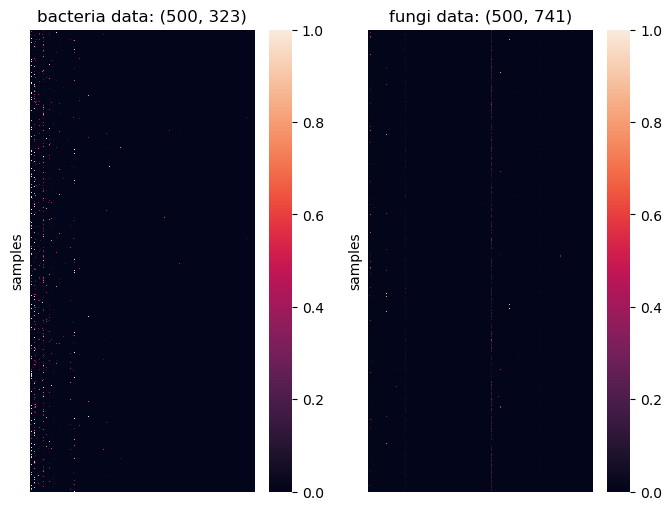

In [291]:
# aggregate similar species and visualise the data this time
bact_agg = aggregate_same_species(bact, bact_tax)
fung_agg = aggregate_same_species(fung, fung_tax)

fig = plt.figure(figsize = (8, 6))

ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(data = bact_agg.set_index('samples'), ax=ax1, yticklabels=False, xticklabels=False)
ax1.set_title(f'bacteria data: {bact_agg.shape}')

ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(data = fung_agg.set_index('samples'), ax=ax2, yticklabels=False, xticklabels=False)
ax2.set_title(f'fungi data: {fung_agg.shape}')

Unfortunately that didn't work that well, while I managed to half the dimensions of the fungi data, it's still too big and both sets of data are still too sparse. Next is to try proper dimensionality reduction techniques. PCA would be the first to come to mind, but it needs the data to be centered first and given how sparse the data is, it won't work at all. So I'm think of truncated SVD or NNMF.